In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sys import stdout
import time
import jax
import jax.numpy as jnp
import numpy as np
import openmm.app as app
import openmm.unit as unit
import openmm as mm
import dmff
from dmff import Hamiltonian, NeighborListFreud, NeighborList
from jax import config
import nglview as nv
from tqdm import tqdm
import mdtraj
import pandas
from scipy.stats import gaussian_kde
from openmm import app, unit, LangevinMiddleIntegrator, System, CustomExternalForce
from openmm.app import Simulation, PDBFile, DCDReporter, StateDataReporter
import time

In [4]:
path = '/Users/siddarthachar/Library/CloudStorage/Box-Box/UChicago-notes/GAD/openmm-tutorial-msbs/02_alanine_dipeptide/'
prmtop = app.AmberPrmtopFile(f"{path}/alanine-dipeptide.prmtop")
inpcrd = app.AmberInpcrdFile(f"{path}/alanine-dipeptide.inpcrd")
ff = Hamiltonian("adp/protein.ff14SB.xml")

# # trying to load amber14 from the openmm data directory 
# openmm_app_path = '/Users/siddarthachar/miniconda3/envs/dmff/lib/python3.9/site-packages/openmm/app/data/'
# app.ForceField('amber14-all.xml')
# ff2 = Hamiltonian(f"{openmm_app_path}/amber14-all.xml")


## Testing to see if DMFF is comparable to OpenMM

In [5]:
potentials = ff.createPotential(prmtop.topology, nonbondedMethod=app.NoCutoff, useDispersionCorrection=False)
params = ff.getParameters()
positions = jnp.array(inpcrd.getPositions(asNumpy=True).value_in_unit(unit.nanometer))

box = jnp.array([[100.0, 0.0, 0.0],
                 [0.0, 100.0, 0.0],
                 [0.0, 0.0, 100.0]])
nbList = NeighborListFreud(box, 3, potentials.meta["cov_map"]) # maybe remove the box?
nbList.allocate(positions)
pairs = nbList.pairs
efunc_all = potentials.getPotentialFunc()
dmff_e = efunc_all(positions, box, pairs, ff.paramset)

print("DMFF Pot E: ", dmff_e)

system = prmtop.createSystem(nonbondedMethod=app.NoCutoff, constraints=None)
integrator = mm.VerletIntegrator(0.001*unit.picoseconds)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(prmtop.topology, system, integrator, platform)
simulation.context.setPositions(inpcrd.positions)

state = simulation.context.getState(getEnergy=True, getVelocities=True, getForces=True, getPositions=True)
energy = state.getPotentialEnergy()
print("OpenMM Pot E: ", energy)
# TODO: figure out why the energy is wrong

mass_adp = np.array([atom.element.mass.value_in_unit(unit.dalton) for atom in prmtop.topology.atoms()])
mass_adp

DMFF Pot E:  -55.79433
OpenMM Pot E:  -88.08858858077855 kJ/mol


array([ 1.007947, 12.01078 ,  1.007947,  1.007947, 12.01078 , 15.99943 ,
       14.00672 ,  1.007947, 12.01078 ,  1.007947, 12.01078 ,  1.007947,
        1.007947,  1.007947, 12.01078 , 15.99943 , 14.00672 ,  1.007947,
       12.01078 ,  1.007947,  1.007947,  1.007947])

### DMFF testing

In [6]:
# trying to recreate the openmm example
start = time.time()
path = '/Users/siddarthachar/Library/CloudStorage/Box-Box/UChicago-notes/GAD/openmm-tutorial-msbs/02_alanine_dipeptide/'
pdb = app.PDBFile(f"{path}/alanine-dipeptide.pdb")
openmm_app_path = '/Users/siddarthachar/miniconda3/envs/dmff/lib/python3.9/site-packages/openmm/app/data/'
ff = Hamiltonian(f"{openmm_app_path}/amber14-all.xml")
potentials = ff.createPotential(pdb.topology, nonbondedMethod=app.NoCutoff, useDispersionCorrection=False)
positions = jnp.array(pdb.getPositions(asNumpy=True).value_in_unit(unit.nanometer))
box = jnp.array([[20.0, 0.0, 0.0], [0.0, 20.0, 0.0], [0.0, 0.0, 20.0]])
nbList = NeighborListFreud(box, 3, potentials.meta["cov_map"]) # maybe remove the box?
nbList.allocate(positions)
pairs = nbList.pairs
efunc_all = potentials.getPotentialFunc()
dmff_e = efunc_all(positions, box, pairs, ff.paramset)
print(dmff_e)
end = time.time()
print(end-start)

<Residue 0 (ACE) of chain 0> is not patched.
<Residue 1 (ALA) of chain 0> is not patched.
<Residue 2 (NME) of chain 0> is not patched.
0
0.028196096420288086


In [7]:
path = '/Users/siddarthachar/Library/CloudStorage/Box-Box/UChicago-notes/GAD/openmm-tutorial-msbs/02_alanine_dipeptide/'
prmtop = app.AmberPrmtopFile(f"{path}/alanine-dipeptide.prmtop")
inpcrd = app.AmberInpcrdFile(f"{path}/alanine-dipeptide.inpcrd")
ff = Hamiltonian(f"adp/protein.ff14SB.xml")
# ff = Hamiltonian(f"{openmm_app_path}/amber14-all.xml")
potentials = ff.createPotential(prmtop.topology, nonbondedMethod=app.NoCutoff, useDispersionCorrection=False)
params = ff.getParameters()
positions = jnp.array(inpcrd.getPositions(asNumpy=True).value_in_unit(unit.nanometer))
box = jnp.array([[20.0, 0.0, 0.0], [0.0, 20.0, 0.0], [0.0, 0.0, 20.0]])
nbList = NeighborListFreud(box, 3, potentials.meta["cov_map"]) # maybe remove the box?
nbList.allocate(positions)
pairs = nbList.pairs
efunc_all = potentials.getPotentialFunc()
dmff_e = efunc_all(positions, box, pairs, ff.paramset)
print("DMFF Pot E: ", dmff_e)


DMFF Pot E:  -55.79433


### OpenMM testing

In [8]:
# openmm testing
path = '/Users/siddarthachar/Library/CloudStorage/Box-Box/UChicago-notes/GAD/openmm-tutorial-msbs/02_alanine_dipeptide/'
prmtop = app.AmberPrmtopFile(f"{path}/alanine-dipeptide.prmtop")
inpcrd = app.AmberInpcrdFile(f"{path}/alanine-dipeptide.inpcrd")
forcefield = app.ForceField(f"adp/protein.ff14SB.xml")
system = forcefield.createSystem(prmtop.topology, nonbondedMethod=app.NoCutoff)
integrator = mm.VerletIntegrator(0.001*unit.picoseconds)
platform = mm.Platform.getPlatformByName('Reference') # check what this is - why is it there? 
simulation = app.Simulation(prmtop.topology, system, integrator, platform) 
simulation.context.setPositions(inpcrd.positions)

state = simulation.context.getState(getEnergy=True, getVelocities=True, getForces=True, getPositions=True)
energy = state.getPotentialEnergy()
print("OpenMM Pot E: ", energy)

OpenMM Pot E:  -55.79426252405782 kJ/mol


In [9]:
# running MD with OpenMM
# openmm testing
path = '/Users/siddarthachar/Library/CloudStorage/Box-Box/UChicago-notes/GAD/openmm-tutorial-msbs/02_alanine_dipeptide/'
prmtop = app.AmberPrmtopFile(f"{path}/alanine-dipeptide.prmtop")
inpcrd = app.AmberInpcrdFile(f"{path}/alanine-dipeptide.inpcrd")
forcefield = app.ForceField(f"adp/protein.ff14SB.xml")
system = forcefield.createSystem(prmtop.topology, nonbondedMethod=app.NoCutoff)
integrator = mm.VerletIntegrator(0.001*unit.picoseconds)
# platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(prmtop.topology, system, integrator)#, platform)
simulation.context.setPositions(inpcrd.positions)

state = simulation.context.getState(getEnergy=True, getVelocities=True, getForces=True, getPositions=True)
energy = state.getPotentialEnergy()
print("OpenMM Pot E: ", energy)
# TODO: Check why the energy is different with the platform (cell above)

OpenMM Pot E:  -55.794219970703125 kJ/mol


In [10]:
path = '/Users/siddarthachar/Library/CloudStorage/Box-Box/UChicago-notes/GAD/openmm-tutorial-msbs/02_alanine_dipeptide/'
prmtop = app.AmberPrmtopFile(f"{path}/alanine-dipeptide.prmtop")
inpcrd = app.AmberInpcrdFile(f"{path}/alanine-dipeptide.inpcrd")
forcefield = app.ForceField(f"adp/protein.ff14SB.xml")
system = forcefield.createSystem(prmtop.topology, nonbondedCutoff=3 * unit.nanometer, constraints=app.HBonds)
# integrator = mm.VerletIntegrator(0.001*unit.picoseconds)
integrator = mm.LangevinIntegrator(300 * unit.kelvin, 1 / unit.picosecond, 2 * unit.femtoseconds)
# platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(prmtop.topology, system, integrator)#, platform)
simulation.context.setPositions(inpcrd.positions)
simulation.minimizeEnergy()

state = simulation.context.getState(getEnergy=True, getVelocities=True, getForces=True, getPositions=True)
energy = state.getPotentialEnergy()
print("OpenMM Pot E: ", energy)
app.statedatareporter.StateDataReporter
# Seems like the initial structure is far from the minimum energy 

OpenMM Pot E:  -86.82528686523438 kJ/mol


openmm.app.statedatareporter.StateDataReporter

In [11]:
simulation.reporters = []
simulation.reporters.append(app.dcdreporter.DCDReporter("traj_openmm_2ns.dcd", 100))
simulation.reporters.append(
    app.statedatareporter.StateDataReporter(stdout, 1000, step=True, temperature=True, elapsedTime=True)
)
simulation.reporters.append(
    app.statedatareporter.StateDataReporter(
        "scalars1_2ns.csv",
        100,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True,
    )
)
start = time.time()
simulation.step(1e6);
end = time.time()
# The last line is only needed for Windows users,
# to close the DCD file before it can be opened by nglview.
del simulation
np.savetxt('time_openmm_2ns.dat', np.array([end-start]))

#"Step","Temperature (K)","Elapsed Time (s)"
1000,239.05590426828869,9.012222290039062e-05
2000,243.62157925373603,0.1413731575012207
3000,298.5958766530143,0.26688408851623535
4000,251.12822999552915,0.3915901184082031
5000,460.4641717105525,0.5132670402526855
6000,255.0496358241311,0.6367223262786865
7000,254.68951556169273,0.7625563144683838
8000,232.09975357928653,0.8894903659820557
9000,275.4180681979558,1.0155820846557617
10000,292.1789636352975,1.1428332328796387
11000,237.92158485208472,1.2680492401123047
12000,321.50606927304744,1.392289161682129
13000,460.9943721192618,1.5191800594329834
14000,461.8573022632196,1.643430233001709
15000,301.52607126809136,1.7704851627349854
16000,279.229956072631,1.8996779918670654
17000,221.24140014429983,2.0243771076202393
18000,280.8620362397472,2.1505470275878906
19000,246.1738443792013,2.2748382091522217
20000,283.2154799369065,2.396804094314575
21000,297.86846069546493,2.5240871906280518
22000,226.14495210964438,2.649123191833496
23000,37

0.05166912078857422


<Axes: xlabel='#"Time (ps)"'>

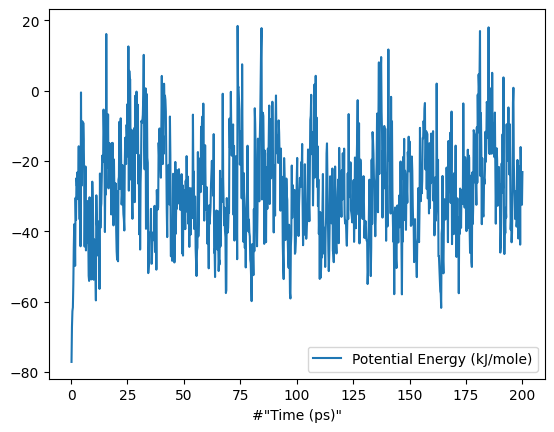

In [140]:
print(end-start)
df1 = pandas.read_csv("scalars1.csv")
plt.close("ener1")
fig, ax = plt.subplots(num="ener1")
df1.plot(kind="line", x='#"Time (ps)"', y="Potential Energy (kJ/mole)", ax=ax)

In [16]:
traj1 = mdtraj.load("traj_openmm.dcd", top=f"{path}/alanine-dipeptide.prmtop")
traj1.superpose(traj1, 0)
nv.show_mdtraj(traj1)

NGLWidget(max_frame=999)

In [7]:
# Ramachandran plot of md
def plot_ramachandran_contour(traj, num, phi_atoms=None, psi_atoms=None, bins=100):
    """Generate a Ramachandran plot with a contour heatmap.

    Parameters
    ----------
    traj : mdtraj.Trajectory
        An MDTraj trajectory object.
    num : str
        Figure name or identifier.
    phi_atoms : list, optional
        List of atom names to define the phi angle.
    psi_atoms : list, optional
        List of atom names to define the psi angle.
    bins : int, optional
        Number of bins for contour density estimation (default: 100).
    """

    # Compute phi and psi angles
    if phi_atoms is None:
        phis = mdtraj.compute_phi(traj)[1].ravel()
    else:
        phis = mdtraj.compute_dihedrals(
            traj, mdtraj.geometry.dihedral._atom_sequence(traj.topology, phi_atoms)[1]
        )

    if psi_atoms is None:
        psis = mdtraj.compute_psi(traj)[1].ravel()
    else:
        psis = mdtraj.compute_dihedrals(
            traj, mdtraj.geometry.dihedral._atom_sequence(traj.topology, psi_atoms)[1]
        )

    # Convert to degrees
    phis = phis * 180 / np.pi
    psis = psis * 180 / np.pi

    # Compute kernel density estimate (KDE)
    values = np.vstack([phis, psis])
    kde = gaussian_kde(values)(values)

    # Create contour plot
    plt.close(num)
    fig, ax = plt.subplots(figsize=(7, 5))
    sc = ax.scatter(phis, psis, c=kde, cmap="viridis", s=5)
    ax.axvline(0, color="k", linestyle="--", lw=1)
    ax.axhline(0, color="k", linestyle="--", lw=1)
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.set_xticks(np.linspace(-180, 180, 5))
    ax.set_yticks(np.linspace(-180, 180, 5))
    ax.set_xlabel("Phi (°)")
    ax.set_ylabel("Psi (°)")
    # ax.set_title("Ramachandran Plot (Contour Density)")
    fig.colorbar(sc, label="Density")

    plt.show()
    return phis, psis

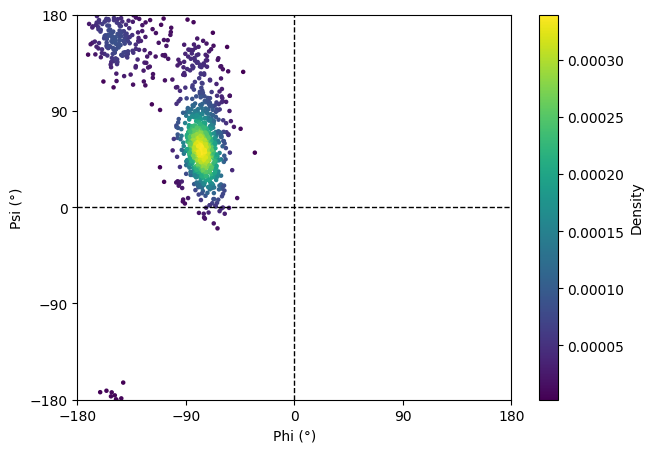

In [21]:
data = plot_ramachandran_contour(traj1, "ram1")


## Computing grad

In [16]:
params = ff.paramset # easy for implemenentation - must not change
efunc_pos = lambda pos: efunc_all(pos.reshape(-1, 3), box, pairs, ff.paramset) # for easy implementation 

grad_vec = jax.grad(efunc_pos)
force = grad_vec(positions.flatten())
print("Forces: \n", force)
force.shape

Forces: 
 [-1.71865784e+02 -3.18554134e+01  6.93357527e-01 -2.69334229e+02
 -3.51437592e+02 -2.29528785e+00 -5.28729582e+00  4.40967636e+01
  4.26398048e+01 -6.79702950e+00  4.33140335e+01 -4.09533348e+01
  4.52542755e+02  2.17767532e+02 -2.35853775e+02  6.63428467e+02
  4.01341003e+02 -3.88142120e+02  9.49903717e+01  7.69634521e+02
  4.01534027e+02 -4.90727539e+01 -4.57673302e+01  7.38116598e+00
 -4.28531311e+02 -3.13665405e+02 -1.89956543e+02  1.74480858e+01
  8.66113377e+00 -4.23281822e+01  1.05135908e+01  1.14673126e+02
  3.50649445e+02 -1.77561817e+01  2.76678715e+01  6.28385620e+01
 -8.25987778e+01  2.01079041e+02  1.30534988e+02 -4.08669006e+02
 -2.61973541e+02  3.33849945e+02  5.80758972e+01 -1.93006954e+01
 -2.68883362e+02  2.16597672e+02  4.39623184e+01  1.80234699e+01
  6.44665375e+01 -3.42623108e+02 -1.88897125e+02  1.40154938e+02
  1.03661865e+02  6.88385963e+00 -2.76112335e+02 -2.02519363e+02
  1.57698691e-01 -3.92051506e+01 -2.84701355e+02  9.30541337e-01
  1.83027859e+0

(66,)

## Computing hessians

In [17]:
def hessian_vec(positions):
  return jax.hessian(efunc_pos)(positions)

hess = hessian_vec(positions.flatten())
print(hess.shape)

# Compute the eigenvalues
w, v = jnp.linalg.eigh(hess)
w_idx = w.argsort()
w = w[w_idx]
v = v[:, w_idx]
v[:,0]

(66, 66)


Array([-0.1099333 ,  0.04464075, -0.16528682, -0.07341945,  0.04509763,
       -0.15736821, -0.04347833,  0.05199321, -0.14249954, -0.07625325,
        0.07158296, -0.14400238, -0.05416021, -0.00742885, -0.17615438,
       -0.0946383 , -0.05392928, -0.22839926, -0.00314558, -0.01106018,
       -0.11434305,  0.00787082,  0.00504006, -0.09827051,  0.00067307,
       -0.01068731,  0.05584005, -0.13841358,  0.04054926,  0.15864685,
        0.21625952, -0.05327325,  0.20737961,  0.30329096, -0.21341099,
        0.10087847,  0.16277698,  0.04635998,  0.27694777,  0.3515909 ,
       -0.03430569,  0.35950732, -0.02877006, -0.00933416, -0.03481681,
       -0.03871948, -0.03031909, -0.157298  , -0.04503867,  0.01730815,
        0.0451954 , -0.03512172,  0.03549021,  0.1269815 , -0.07119063,
        0.01694606,  0.02515984, -0.0777181 , -0.00178101,  0.10531217,
       -0.00426837,  0.03769545, -0.02197921, -0.14829455,  0.01276331,
       -0.02133119], dtype=float32)

### GAD function

In [18]:
def gad_force_vec(position, kappa=0.9):
    '''
    position is Nx3 vector, N = number of atoms
    
    More efficient way to do this by passing forces_u in addition to position so don't have to double compute force_u,
    but annoying to use like this within BAOAB function
    
    Also annoying to hard-code kappa=XX into this function, but again annoying not to do so within BAOAB
    
    Should probably write custom BAOAB to accommodate
    '''

    # checking kappa is softening parameter
    assert 0. <= kappa <= 1.
        
    # unbiased forces
    forces_u = grad_vec(position.flatten())
    
    # biased forces (softened by kappa)
    hess = hessian_vec(positions.flatten())

    w, v = jnp.linalg.eigh(hess)
    w_idx = w.argsort()
    w = w[w_idx]
    v = v[:, w_idx]
    n = v[:,0]

    # Normalize the eigenvector
    n = n / jnp.linalg.norm(n)

    # Compute the biased forces
    forces_b = -jnp.dot(n, forces_u) * n  # Shape: (n_atoms * n_dims,)
    forces_b *= kappa

    forces_b = forces_b.reshape((position.shape))
    return forces_b

f_b = gad_force_vec(positions)

In [19]:
# Define the path and load files
path = '/Users/siddarthachar/Library/CloudStorage/Box-Box/UChicago-notes/GAD/openmm-tutorial-msbs/02_alanine_dipeptide/'
prmtop = app.AmberPrmtopFile(f"{path}/alanine-dipeptide.prmtop")
inpcrd = app.AmberInpcrdFile(f"{path}/alanine-dipeptide.inpcrd")

# Create the system
forcefield = app.ForceField("adp/protein.ff14SB.xml")
system = forcefield.createSystem(prmtop.topology, nonbondedCutoff=3 * unit.nanometer, constraints=app.HBonds)

# Create a custom external force to apply biased forces
biased_force = CustomExternalForce("fx*x+fy*y+fz*z")
biased_force.addPerParticleParameter("fx")  # Add fx as a per-particle parameter
biased_force.addPerParticleParameter("fy")  # Add fy as a per-particle parameter
biased_force.addPerParticleParameter("fz")  # Add fz as a per-particle parameter
system.addForce(biased_force)

# Add a particle for each atom in the system
# Initialize with zero forces
for i in range(system.getNumParticles()):
    biased_force.addParticle(i, [0.0, 0.0, 0.0])  # fx, fy, fz initialized to 0

# Create the integrator and simulation
integrator = LangevinMiddleIntegrator(300 * unit.kelvin, 1 / unit.picosecond, 2 * unit.femtoseconds)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)

# Minimize the energy
simulation.minimizeEnergy()

# Check the initial energy
state = simulation.context.getState(getEnergy=True)
energy = state.getPotentialEnergy()
print("OpenMM Pot E: ", energy)

OpenMM Pot E:  -86.82528686523438 kJ/mol


In [20]:
# Function to update biased forces
def update_biased_forces(simulation, biased_force, get_biased_forces):
    # get the current state
    state = simulation.context.getState(getPositions=True)
    positions = state.getPositions(asNumpy=True).value_in_unit(unit.nanometer)

    # compute biased forces using your function
    biased_forces = get_biased_forces(positions)  # Shape: (N, 3)

    # update the custom external force
    for i in range(system.getNumParticles()):
        biased_force.setParticleParameters(i, i, (biased_forces[i, 0], biased_forces[i, 1], biased_forces[i, 2]))
    biased_force.updateParametersInContext(simulation.context)

# add a reporter to update forces every 100 steps
class ForceUpdaterReporter:
    def __init__(self, simulation, biased_force, get_biased_forces, interval):
        self.simulation = simulation
        self.biased_force = biased_force
        self.get_biased_forces = get_biased_forces
        self.interval = interval

    def describeNextReport(self, simulation):
        """
        Return the number of steps until the next report and what data to collect.
        The five `False` values indicate that this reporter does not require any specific data.
        """
        return (self.interval, False, False, False, False, False)

    def report(self, simulation, state):
        """
        This function will be called at intervals specified in describeNextReport().
        It updates the biased forces using the provided function.
        """
        update_biased_forces(self.simulation, self.biased_force, self.get_biased_forces)

simulation.reporters = []
simulation.reporters.append(DCDReporter("traj_openmm_gad_2ns.dcd", 100))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter("scalars1_gad_2ns.csv", 100, time=True, potentialEnergy=True, totalEnergy=True, temperature=True))
simulation.reporters.append(ForceUpdaterReporter(simulation, biased_force, gad_force_vec, 100))

start = time.time()
simulation.step(1e6)
end = time.time()
# The last line is only needed for Windows users,
# to close the DCD file before it can be opened by nglview.
del simulation
np.savetxt('time_openmm_gad_2ns.dat', np.array([end-start]))

#"Step","Temperature (K)","Elapsed Time (s)"
1000,266.58722990449303,8.392333984375e-05
2000,270.4643298812857,2.0902931690216064
3000,431.4043135233375,4.179885149002075
4000,766.7189385380029,6.32183313369751
5000,558.7311915663284,8.40098524093628
6000,1445.093287951593,10.554590940475464
7000,530.9135589133563,12.615025281906128
8000,1276.801190597906,14.667541027069092
9000,718.813525283116,16.96766209602356
10000,447.02468052808337,19.089454174041748
11000,1253.5917528747034,21.382601976394653
12000,637.9811320833277,23.591567277908325
13000,566.3338037795702,25.95031714439392
14000,463.2649192557206,28.102278232574463
15000,1008.0606324967582,30.195141077041626
16000,1302.1138625524745,32.3836030960083
17000,423.0922634152902,34.474587202072144
18000,474.9979550835556,36.61617302894592
19000,806.8666521515046,38.8174090385437
20000,1085.962554397764,40.874197006225586
21000,908.6580805043011,42.902194023132324
22000,483.3946416249071,44.94551396369934
23000,987.9545460531879,47.

In [110]:
state = simulation.context.getState(getPositions=True)
positions = state.getPositions(asNumpy=True).value_in_unit(unit.nanometers)
traj = mdtraj.Trajectory(positions[None, :, :], mdtraj.Topology().from_openmm(prmtop.topology))


In [10]:
path = '/Users/siddarthachar/Library/CloudStorage/Box-Box/UChicago-notes/GAD/openmm-tutorial-msbs/02_alanine_dipeptide/'
traj1 = mdtraj.load("traj_openmm_gad_2ns.dcd", top=f"{path}/alanine-dipeptide.prmtop")
traj2 = mdtraj.load("traj_openmm_2ns.dcd", top=f"{path}/alanine-dipeptide.prmtop")

nv.show_mdtraj(traj1)

NGLWidget(max_frame=9999)

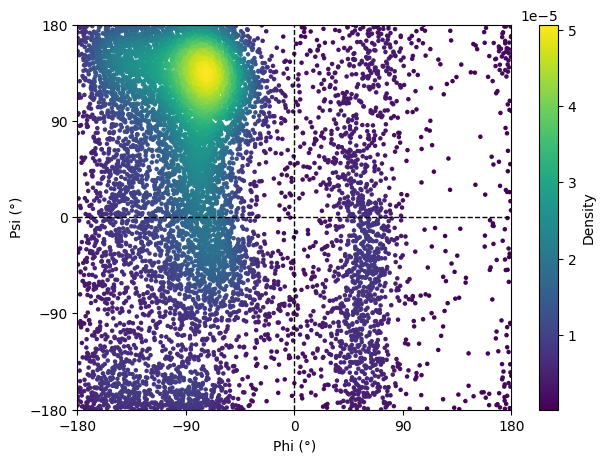

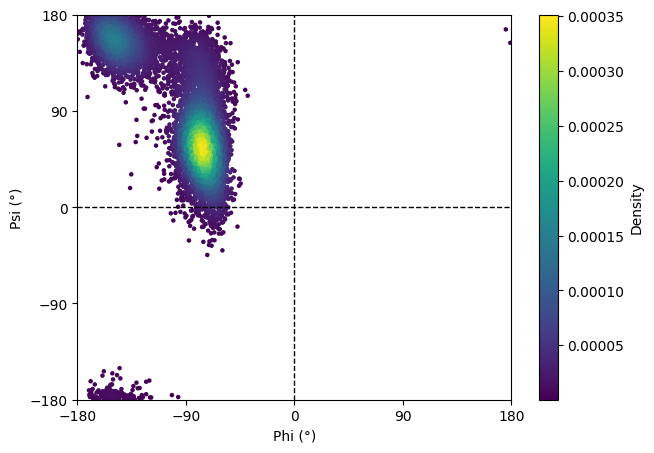

In [11]:
data1 = plot_ramachandran_contour(traj1, 'gad')
data2 = plot_ramachandran_contour(traj2, 'unbiased')

In [116]:
simulation.context.getState(getPositions=True)

<openmm.openmm.State; proxy of <Swig Object of type 'OpenMM::State *' at 0x163bc1870> >